In [ ]:
"""
Convole script:

1) Read data from all 7 sectors
2) Split up into chunks based on cmd line input
3) Write partial results
4) If time, make faster



"""

In [149]:
import numpy as np
from scipy.stats import norm
from scipy.signal import fftconvolve
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table, Column
import time
import glob
import os.path as p

def tconvolve(tess_dir,batman_dir, sector, start, end, output_dir, verbosity=0):
    """
    
    Parameters
    ----------
    tess_dir(str): directory to TESS data
    batman_dir (str): directory to model data
    sector (int): sector to pull data from
    start (int): file to start at
    end (int): file to end at
    output_dir (str): directory to write candidates.csv
    """
    tconv_start = time.time()
    print("===START TCONVOLVE===")
    
    # Read in TESS Sector data
    print("Reading TESS data...")
    sector_name = "Sector{}".format(sector)
    if sector == 0:
        sector_name = "sample_"+sector_name
    sector_path = p.join(tess_dir, sector_name)
    sector_files = glob.glob(p.join(sector_path,"*.fits"))
    tess_names = sector_files[start:end]
    ntess = len(tess_names)
    print("Found {} TESS files to process".format(ntess))

    # Read in Batman Curves 
    print("Reading Batman transit curves...")
    batmanCurves = ascii.read(p.join(batman_dir,"batmanCurves_small.csv"), 
                       data_start=1, format='csv')
    times = np.array(batmanCurves['times'])
    curve_names = np.array(batmanCurves.colnames[1:])
    nbatman = len(curve_names)
    print("Found {} Batman curves".format(nbatman))
    
    nerr = 0  # count number of failed files
    # Do convolution on all tess files
    for tess_fpath in tess_names:
        tess_fname = p.basename(tess_fpath)
        print("Starting TESS file: {}".format(tess_fname))
        tess_start = time.time()

        try:
            with fits.open(tess_fpath, mode="readonly") as hdulist:
                hdr = hdulist[0].header
                tess_time = hdulist[1].data['TIME']
                tess_flux = hdulist[1].data['PDCSAP_FLUX']
        except Exception as e: 
            print("ERROR reading file: ", tess_fpath, " with error: ", e)
            nerr += 1
            continue  # skip to next loop iter
        
        # clean tess lightcurve of nans
        med = np.nanmedian(tess_flux)
        tess_flux[np.isnan(tess_flux)] = med
        
        tmean = np.mean(tess_flux)
        tstd = np.std(tess_flux)
        tess_flux = (tess_flux - tmean)/tstd
        
        # Do convolution on each batman curve
        max_array=np.zeros(nbatman)
        tmax_array=np.zeros(nbatman)
        conv_start = time.time()
        print("Starting convolutions...")
        for j, curvename in enumerate(curve_names):
            # make batman same len at tess
            batman_curve = batmanCurves[curvename]
#             batman_flux_nopad = batmanCurves[curvename]
#             len_diff = len(tess_time)-len(batman_flux_nopad)
#             batman_flux = np.pad(batman_flux_nopad, (len_diff, 0), 'constant', constant_values=(1,1))
            
            # run convolution
            convolution = fftconvolve(tess_flux, batman_curve, 'same')
#             batman_FFT=np.fft.fft(batman_flux)
#             tess_FFT=np.fft.fft(tess_flux)
#             convolution=(np.absolute(np.fft.ifft((batman_FFT)*(tess_FFT))))
            
            # Save max conv value and time
            ind_max = np.argmin(convolution)
            tmax_array[j] = tess_time[ind_max]
            max_array[j] = convolution[ind_max]
        conv_time = time.time() - conv_start
        print("Convolved {} curves in {:.3} s".format(nbatman, conv_time))
        
        # Keep best curves
        print(max_array)
        return max_array
        mu, std = norm.fit(max_array)
        print(mu, std)
        idxs = np.where(max_array >= mu+3*std)
        print(idxs)
        convs = max_array[idxs]
        times = tmax_array[idxs]
        curves = curve_names[idxs]
        nfitcurves = len(curves)
        print("Found: {} fitting curves".format(nfitcurves))
        

        # Make table
        outname = 'candidates_s{}_b{}_e{}_{}.csv'.format(sector,start,end,tess_fname)
        outpath = p.join(output_dir, outname)
        print("Writing table: {}".format(outname))
        candidates = Table()
        candidates.add_column(Column([sector_name]*nfitcurves), name="sector")
        candidates.add_column(Column([tess_fname]*nfitcurves), name="tessFile")
        candidates.add_column(Column(curves), name="curveID")
        candidates.add_column(Column(times), name="tcorr")
        candidates.add_column(Column(convs), name="correlation")
        
        ascii.write(candidates, outpath, format='csv', overwrite=True, comment='#')
        tess_time = time.time() - tess_start
        print("Finished tess file in {:.3} s".format(tess_time))
    
    tconv_time = time.time() - tconv_start
    print("Convolved {}/{} tess files and {} curves in {:.3} s".format(ntess-nerr, ntess, nbatman, tconv_time))
    print("===END TCONVOLVE===")
    
def main():
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument("tess_dir", type=str)
    parser.add_argument("batman_dir", type=str)
    parser.add_argument("sector", type=int)
    parser.add_argument("start", type=int)
    parser.add_argument("end", type=int)
    parser.add_argument("output_dir", type=str)
    parser.add_argument("-v", "--verbosity", default=False, 
                        action="store_true", help="Print console output")
    args = parser.parse_args()
    tconvolve(args.tess_dir, args.batman_dir, args.sector, args.start, 
          args.end, args.output_dir, args.verbosity)
          
# if __name__ == '__main__':
#     main()

In [150]:
tess_dir="/home/ctaiudovicic/projects/tess_batman/sampleData/"
batman_dir="/home/ctaiudovicic/projects/tess_batman/data/"
sector=0
start=0
end=15
output_dir= "/home/ctaiudovicic/projects/tess_batman/data/tmp/"
verbosity=0
tconvolve(tess_dir,batman_dir, sector, start, end, output_dir, verbosity=0)


===START TCONVOLVE===
Reading TESS data...
Found 10 TESS files to process
Reading Batman transit curves...
Found 2560 Batman curves
Starting TESS file: HD_1397_b.fits
Starting convolutions...
Convolved 2560 curves in 1.27 s
[41391831.37049121 41397485.52127567 41414831.36034053 ...
 41918525.16276349 41918525.16276349 41918525.16276351]
41909849.197456144 39060.642338070684
(array([], dtype=int64),)
Found: 0 fitting curves
Writing table: candidates_s0_b0_e15_HD_1397_b.fits.csv


UnboundLocalError: local variable 'i' referenced before assignment

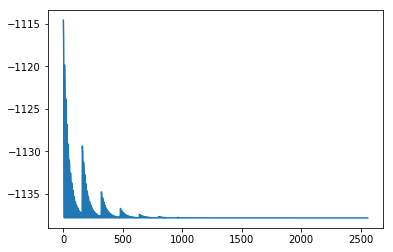

In [147]:
import matplotlib.pyplot as plt
plt.plot(arr)

In [137]:
# Read in TESS Sector data
print("Reading TESS data...")
sector_name = "Sector{}".format(sector)
if sector == 0:
    sector_name = "sample_"+sector_name
sector_path = p.join(tess_dir, sector_name)
sector_files = glob.glob(p.join(sector_path,"*.fits"))
tess_names = sector_files[start:end]
ntess = len(tess_names)
print("Found {} TESS files to process".format(ntess))

# Read in Batman Curves 
print("Reading Batman transit curves...")
batmanCurves = ascii.read(p.join(batman_dir,"batmanCurves_small.csv"), 
                   data_start=1, format='csv')
times = np.array(batmanCurves['times'])
curve_names = np.array(batmanCurves.colnames[1:])
nbatman = len(curve_names)
print("Found {} Batman curves".format(nbatman))

nerr = 0  # count number of failed files
# Do convolution on all tess files
tess_fpath = tess_names[0]
tess_fname = p.basename(tess_fpath)
print("Starting TESS file: {}".format(tess_fname))
tess_start = time.time()

try:
    with fits.open(tess_fpath, mode="readonly") as hdulist:
        hdr = hdulist[0].header
        tess_time = hdulist[1].data['TIME']
        tess_flux = hdulist[1].data['PDCSAP_FLUX']
except Exception as e: 
    print("ERROR reading file: ", tess_fpath, " with error: ", e)
    nerr += 1
    #continue  # skip to next loop iter

# clean tess lightcurve of nans
med = np.nanmedian(tess_flux)
tess_flux[np.isnan(tess_flux)] = med

tmean = np.mean(tess_flux)
tstd = np.std(tess_flux)
tess_flux = (tess_flux - tmean)/tstd
# Do convolution on each batman curve
max_array=np.zeros(nbatman)
tmax_array=np.zeros(nbatman)
conv_start = time.time()
print("Starting convolutions...")
j = 0
curvename = curve_names[0]

batman_flux = batmanCurves[curvename]
convolution = np.convolve(tess_flux, batman_flux, 'same')

Reading TESS data...
Found 10 TESS files to process
Reading Batman transit curves...
Found 2560 Batman curves
Starting TESS file: HD_1397_b.fits
Starting convolutions...


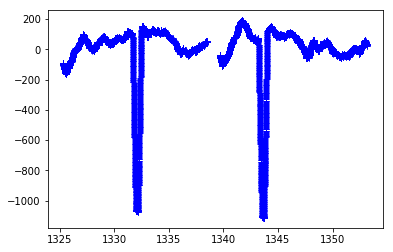

In [139]:
plt.plot(tess_time,convolution, 'b+')

In [98]:
ind_max = np.argmax(convolution)
tmax = tess_time[ind_max]
cmax = convolution[ind_max]
print(ind_max, tmax, cmax)

6034 1333.6779213298512 82803366.2285856
